In [1]:
import os, random, math, json
from pathlib import Path
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# === YOUR DATASET PATHS ===
IMAGES_DIR = r"C:\Users\me1mna\Downloads\Defects location for metal surface\images\images"
LABELS_DIR = r"C:\Users\me1mna\Downloads\Defects location for metal surface\label\label"

print("IMAGES_DIR =", IMAGES_DIR)
print("LABELS_DIR =", LABELS_DIR)

# XML parsing helper
def parse_xml_file(xml_path):
    root = ET.parse(xml_path).getroot()
    fn = root.findtext("filename")
    size = root.find("size")
    w = int(size.findtext("width")); h = int(size.findtext("height"))
    boxes = []
    for obj in root.findall("object"):
        bb = obj.find("bndbox")
        xmin = int(bb.findtext("xmin")); ymin = int(bb.findtext("ymin"))
        xmax = int(bb.findtext("xmax")); ymax = int(bb.findtext("ymax"))
        boxes.append((xmin, ymin, xmax, ymax))
    return fn, (w, h), boxes


IMAGES_DIR = C:\Users\me1mna\Downloads\Defects location for metal surface\images\images
LABELS_DIR = C:\Users\me1mna\Downloads\Defects location for metal surface\label\label


In [2]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

images_dir = Path(IMAGES_DIR)
labels_dir = Path(LABELS_DIR)

# Collect images recursively
img_files = [p for p in images_dir.rglob("*") if p.is_file() and p.suffix.lower() in IMG_EXTS]
print(f"Found {len(img_files)} image files under {images_dir}")

# Map filename -> path, and filename -> class folder
fname_to_path = {p.name: p for p in img_files}
fname_to_folder = {p.name: p.parent.name for p in img_files}

# Collect XMLs
xml_files = sorted(labels_dir.glob("*.xml"))
print(f"Found {len(xml_files)} XML files in {labels_dir}")

# Match XMLs to images
xml_fns = []
for xf in xml_files:
    try:
        fn, _, _ = parse_xml_file(xf)
        xml_fns.append(fn)
    except Exception as e:
        print(f"[WARN] Failed parse {xf.name}: {e}")

xml_set = set(xml_fns)
img_set = set(fname_to_path.keys())
missing = sorted(fn for fn in xml_set if fn not in img_set)
orphans = sorted(fn for fn in img_set if fn not in xml_set)
print(f"XML refs missing images: {len(missing)} | Orphan images: {len(orphans)}")


Found 2306 image files under C:\Users\me1mna\Downloads\Defects location for metal surface\images\images
Found 2280 XML files in C:\Users\me1mna\Downloads\Defects location for metal surface\label\label
XML refs missing images: 0 | Orphan images: 14


In [3]:
records = []
bad = []

for xf in xml_files:
    try:
        fn, size_wh, boxes = parse_xml_file(xf)
        img_path = fname_to_path.get(fn)
        folder_label = fname_to_folder.get(fn)
        if img_path is None or folder_label is None:
            bad.append((xf.name, "image_missing_or_no_class_folder"))
            continue
        records.append({
            "image_path": str(img_path),
            "filename": fn,
            "folder_label": folder_label,
            "boxes": boxes,
            "size": size_wh,
            "xml_path": str(xf),
        })
    except Exception as e:
        bad.append((xf.name, f"parse_error:{e}"))

print(f"Parsed records: {len(records)} | Skipped: {len(bad)})")

per_class = Counter(r["folder_label"] for r in records)
label_names = sorted(per_class.keys())
label2id = {n:i for i,n in enumerate(label_names)}
id2label = {i:n for n,i in label2id.items()}

print("\nClasses:")
for i,n in enumerate(label_names):
    print(f"  {i}: {n} (images: {per_class[n]})")


Parsed records: 2280 | Skipped: 0)

Classes:
  0: crease (images: 51)
  1: crescent_gap (images: 224)
  2: inclusion (images: 211)
  3: oil_spot (images: 204)
  4: punching_hole (images: 215)
  5: rolled_pit (images: 28)
  6: silk_spot (images: 649)
  7: waist folding (images: 144)
  8: water_spot (images: 287)
  9: welding_line (images: 267)


In [4]:
KAGGLE_IMG_SIZE = (224, 224)
NUM_CLASSES = len(label2id)

kaggle_samples = []
for r in records:
    if not r["boxes"]:
        continue
    (xmin, ymin, xmax, ymax) = r["boxes"][0]
    W, H = r["size"]
    x1 = np.clip(xmin / W, 0.0, 1.0)
    y1 = np.clip(ymin / H, 0.0, 1.0)
    x2 = np.clip(xmax / W, 0.0, 1.0)
    y2 = np.clip(ymax / H, 0.0, 1.0)
    onehot = np.zeros(NUM_CLASSES, dtype=np.float32)
    onehot[label2id[r["folder_label"]]] = 1.0
    kaggle_samples.append({
        "image_path": r["image_path"],
        "bbox": [xmin, ymin, xmax, ymax],
        "class_id": int(np.argmax(onehot))
    })

print("Total samples:", len(kaggle_samples))


Total samples: 2280


In [5]:
random.seed(42)
by_cls = defaultdict(list)
for s in kaggle_samples:
    by_cls[s["class_id"]].append(s)

train_samples, val_samples = [], []
VAL_FRAC = 0.2
for cls_id, items in by_cls.items():
    random.shuffle(items)
    n_val = max(1, int(len(items) * VAL_FRAC))
    val_samples.extend(items[:n_val])
    train_samples.extend(items[n_val:])

# Balance training set
counts = Counter(s["class_id"] for s in train_samples)
max_count = max(counts.values())
bucket = defaultdict(list)
for s in train_samples:
    bucket[s["class_id"]].append(s)

train_balanced = []
for c, items in bucket.items():
    extra = [random.choice(items) for _ in range(max_count - len(items))]
    train_balanced.extend(items + extra)

random.shuffle(train_balanced)
print("Train size:", len(train_balanced), "| Val size:", len(val_samples))


Train size: 5200 | Val size: 451


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class MetalSurfaceDataset(Dataset):
    def __init__(self, samples, transforms=None):
        self.samples = samples
        self.transforms = transforms

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img = Image.open(sample["image_path"]).convert("RGB")
        boxes = torch.tensor([sample["bbox"]], dtype=torch.float32)
        labels = torch.tensor([sample["class_id"]+1], dtype=torch.int64)  # class 0 = background
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.samples)

transform = T.ToTensor()

train_dataset = MetalSurfaceDataset(train_balanced, transforms=transform)
val_dataset   = MetalSurfaceDataset(val_samples, transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load pre-trained Faster R-CNN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace head for our dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES+1)  # +1 for background

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
import torch
from torchvision.ops import box_iou
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to GPU
model.to(device)

# Optimizer
import torch.optim as optim
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 50
iou_threshold = 0.5  # For mAP@0.5

def evaluate(model, data_loader, device):
    model.eval()
    ious = []
    all_precisions = []
    all_recalls = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                gt_boxes = target["boxes"].cpu()
                pred_boxes = output["boxes"].cpu()
                if len(gt_boxes) == 0 or len(pred_boxes) == 0:
                    continue

                iou = box_iou(pred_boxes, gt_boxes)
                max_iou_per_pred, _ = iou.max(dim=1)

                # IoU for reporting
                ious.extend(max_iou_per_pred.numpy())

                # mAP@0.5 calculation (precision & recall)
                tp = (max_iou_per_pred >= iou_threshold).sum().item()
                fp = (max_iou_per_pred < iou_threshold).sum().item()
                fn = max(len(gt_boxes) - tp, 0)

                precision = tp / (tp + fp) if tp + fp > 0 else 0
                recall = tp / (tp + fn) if tp + fn > 0 else 0

                all_precisions.append(precision)
                all_recalls.append(recall)

    model.train()

    mean_iou = np.mean(ious) if ious else 0
    mean_precision = np.mean(all_precisions) if all_precisions else 0
    mean_recall = np.mean(all_recalls) if all_recalls else 0
    mean_ap = mean_precision  # For IoU threshold = 0.5, AP ~ Precision

    return mean_iou, mean_ap, mean_precision, mean_recall


# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, targets in loop:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        loop.set_postfix(loss=losses.item())

    avg_loss = total_loss / len(train_loader)

    # Evaluate after epoch
    miou, map50, precision, recall = evaluate(model, val_loader, device)
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Avg Loss: {avg_loss:.4f}")
    print(f"  mIoU: {miou:.4f}")
    print(f"  mAP@0.5: {map50:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")


Using device: cuda


Epoch 1/50: 100%|██████████| 1300/1300 [17:38<00:00,  1.23batch/s, loss=0.13]  



Epoch 1 Summary:
  Avg Loss: 0.2035
  mIoU: 0.2646
  mAP@0.5: 0.3810
  Precision: 0.3810
  Recall: 0.9413


Epoch 2/50: 100%|██████████| 1300/1300 [17:37<00:00,  1.23batch/s, loss=0.113] 



Epoch 2 Summary:
  Avg Loss: 0.1278
  mIoU: 0.3162
  mAP@0.5: 0.4021
  Precision: 0.4021
  Recall: 0.9239


Epoch 3/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.142] 



Epoch 3 Summary:
  Avg Loss: 0.1067
  mIoU: 0.3284
  mAP@0.5: 0.4317
  Precision: 0.4317
  Recall: 0.9056


Epoch 4/50: 100%|██████████| 1300/1300 [17:27<00:00,  1.24batch/s, loss=0.0958]



Epoch 4 Summary:
  Avg Loss: 0.0908
  mIoU: 0.3623
  mAP@0.5: 0.4760
  Precision: 0.4760
  Recall: 0.8758


Epoch 5/50: 100%|██████████| 1300/1300 [17:27<00:00,  1.24batch/s, loss=0.0931]



Epoch 5 Summary:
  Avg Loss: 0.0817
  mIoU: 0.3798
  mAP@0.5: 0.5142
  Precision: 0.5142
  Recall: 0.8793


Epoch 6/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.0821]



Epoch 6 Summary:
  Avg Loss: 0.0747
  mIoU: 0.3645
  mAP@0.5: 0.5056
  Precision: 0.5056
  Recall: 0.8919


Epoch 7/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.037] 



Epoch 7 Summary:
  Avg Loss: 0.0672
  mIoU: 0.3634
  mAP@0.5: 0.5231
  Precision: 0.5231
  Recall: 0.8761


Epoch 8/50: 100%|██████████| 1300/1300 [17:29<00:00,  1.24batch/s, loss=0.0452]



Epoch 8 Summary:
  Avg Loss: 0.0624
  mIoU: 0.3604
  mAP@0.5: 0.4876
  Precision: 0.4876
  Recall: 0.8736


Epoch 9/50: 100%|██████████| 1300/1300 [17:27<00:00,  1.24batch/s, loss=0.0399]



Epoch 9 Summary:
  Avg Loss: 0.0600
  mIoU: 0.3897
  mAP@0.5: 0.5323
  Precision: 0.5323
  Recall: 0.8764


Epoch 10/50: 100%|██████████| 1300/1300 [17:33<00:00,  1.23batch/s, loss=0.0483]



Epoch 10 Summary:
  Avg Loss: 0.0587
  mIoU: 0.3200
  mAP@0.5: 0.4362
  Precision: 0.4362
  Recall: 0.8626


Epoch 11/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.0613]



Epoch 11 Summary:
  Avg Loss: 0.0557
  mIoU: 0.3589
  mAP@0.5: 0.4973
  Precision: 0.4973
  Recall: 0.8899


Epoch 12/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.0468]



Epoch 12 Summary:
  Avg Loss: 0.0526
  mIoU: 0.2718
  mAP@0.5: 0.3772
  Precision: 0.3772
  Recall: 0.8507


Epoch 13/50: 100%|██████████| 1300/1300 [17:26<00:00,  1.24batch/s, loss=0.0242]



Epoch 13 Summary:
  Avg Loss: 0.0531
  mIoU: 0.3982
  mAP@0.5: 0.5746
  Precision: 0.5746
  Recall: 0.8736


Epoch 14/50: 100%|██████████| 1300/1300 [17:30<00:00,  1.24batch/s, loss=0.0664]



Epoch 14 Summary:
  Avg Loss: 0.0507
  mIoU: 0.3461
  mAP@0.5: 0.5093
  Precision: 0.5093
  Recall: 0.8610


Epoch 15/50: 100%|██████████| 1300/1300 [17:31<00:00,  1.24batch/s, loss=0.0506]



Epoch 15 Summary:
  Avg Loss: 0.0496
  mIoU: 0.3625
  mAP@0.5: 0.4864
  Precision: 0.4864
  Recall: 0.8770


Epoch 16/50: 100%|██████████| 1300/1300 [17:26<00:00,  1.24batch/s, loss=0.0406]



Epoch 16 Summary:
  Avg Loss: 0.0495
  mIoU: 0.4013
  mAP@0.5: 0.5697
  Precision: 0.5697
  Recall: 0.8782


Epoch 17/50: 100%|██████████| 1300/1300 [17:25<00:00,  1.24batch/s, loss=0.0761]



Epoch 17 Summary:
  Avg Loss: 0.0498
  mIoU: 0.3656
  mAP@0.5: 0.5040
  Precision: 0.5040
  Recall: 0.8821


Epoch 18/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.074] 



Epoch 18 Summary:
  Avg Loss: 0.0477
  mIoU: 0.3889
  mAP@0.5: 0.5415
  Precision: 0.5415
  Recall: 0.8652


Epoch 19/50: 100%|██████████| 1300/1300 [17:31<00:00,  1.24batch/s, loss=0.0224]



Epoch 19 Summary:
  Avg Loss: 0.0475
  mIoU: 0.3284
  mAP@0.5: 0.4499
  Precision: 0.4499
  Recall: 0.8824


Epoch 20/50: 100%|██████████| 1300/1300 [17:34<00:00,  1.23batch/s, loss=0.0659]



Epoch 20 Summary:
  Avg Loss: 0.0480
  mIoU: 0.4422
  mAP@0.5: 0.6094
  Precision: 0.6094
  Recall: 0.8732


Epoch 21/50: 100%|██████████| 1300/1300 [17:48<00:00,  1.22batch/s, loss=0.0517]



Epoch 21 Summary:
  Avg Loss: 0.0457
  mIoU: 0.4037
  mAP@0.5: 0.5604
  Precision: 0.5604
  Recall: 0.8515


Epoch 22/50: 100%|██████████| 1300/1300 [17:27<00:00,  1.24batch/s, loss=0.0378]



Epoch 22 Summary:
  Avg Loss: 0.0471
  mIoU: 0.3877
  mAP@0.5: 0.5634
  Precision: 0.5634
  Recall: 0.8571


Epoch 23/50: 100%|██████████| 1300/1300 [17:30<00:00,  1.24batch/s, loss=0.0437]



Epoch 23 Summary:
  Avg Loss: 0.0476
  mIoU: 0.3867
  mAP@0.5: 0.5518
  Precision: 0.5518
  Recall: 0.8585


Epoch 24/50: 100%|██████████| 1300/1300 [17:33<00:00,  1.23batch/s, loss=0.0295]



Epoch 24 Summary:
  Avg Loss: 0.0459
  mIoU: 0.3655
  mAP@0.5: 0.5266
  Precision: 0.5266
  Recall: 0.8545


Epoch 25/50: 100%|██████████| 1300/1300 [17:25<00:00,  1.24batch/s, loss=0.0427]



Epoch 25 Summary:
  Avg Loss: 0.0448
  mIoU: 0.3881
  mAP@0.5: 0.5353
  Precision: 0.5353
  Recall: 0.8424


Epoch 26/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.0448]



Epoch 26 Summary:
  Avg Loss: 0.0438
  mIoU: 0.2731
  mAP@0.5: 0.3638
  Precision: 0.3638
  Recall: 0.8886


Epoch 27/50: 100%|██████████| 1300/1300 [17:30<00:00,  1.24batch/s, loss=0.0335]



Epoch 27 Summary:
  Avg Loss: 0.0447
  mIoU: 0.3539
  mAP@0.5: 0.4835
  Precision: 0.4835
  Recall: 0.8610


Epoch 28/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.025] 



Epoch 28 Summary:
  Avg Loss: 0.0446
  mIoU: 0.4000
  mAP@0.5: 0.5439
  Precision: 0.5439
  Recall: 0.8522


Epoch 29/50: 100%|██████████| 1300/1300 [17:29<00:00,  1.24batch/s, loss=0.0398]



Epoch 29 Summary:
  Avg Loss: 0.0460
  mIoU: 0.3963
  mAP@0.5: 0.5737
  Precision: 0.5737
  Recall: 0.8545


Epoch 30/50: 100%|██████████| 1300/1300 [17:30<00:00,  1.24batch/s, loss=0.0442]



Epoch 30 Summary:
  Avg Loss: 0.0433
  mIoU: 0.4081
  mAP@0.5: 0.5626
  Precision: 0.5626
  Recall: 0.8314


Epoch 31/50: 100%|██████████| 1300/1300 [17:29<00:00,  1.24batch/s, loss=0.0441]



Epoch 31 Summary:
  Avg Loss: 0.0449
  mIoU: 0.3391
  mAP@0.5: 0.4954
  Precision: 0.4954
  Recall: 0.8409


Epoch 32/50: 100%|██████████| 1300/1300 [17:26<00:00,  1.24batch/s, loss=0.0242]



Epoch 32 Summary:
  Avg Loss: 0.0414
  mIoU: 0.3906
  mAP@0.5: 0.5459
  Precision: 0.5459
  Recall: 0.8531


Epoch 33/50: 100%|██████████| 1300/1300 [17:29<00:00,  1.24batch/s, loss=0.0374]



Epoch 33 Summary:
  Avg Loss: 0.0441
  mIoU: 0.3735
  mAP@0.5: 0.5342
  Precision: 0.5342
  Recall: 0.8561


Epoch 34/50: 100%|██████████| 1300/1300 [17:31<00:00,  1.24batch/s, loss=0.0411]



Epoch 34 Summary:
  Avg Loss: 0.0442
  mIoU: 0.3479
  mAP@0.5: 0.4955
  Precision: 0.4955
  Recall: 0.8481


Epoch 35/50: 100%|██████████| 1300/1300 [17:27<00:00,  1.24batch/s, loss=0.0883]



Epoch 35 Summary:
  Avg Loss: 0.0445
  mIoU: 0.3192
  mAP@0.5: 0.4336
  Precision: 0.4336
  Recall: 0.8345


Epoch 36/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.106] 



Epoch 36 Summary:
  Avg Loss: 0.0428
  mIoU: 0.3421
  mAP@0.5: 0.4740
  Precision: 0.4740
  Recall: 0.8505


Epoch 37/50: 100%|██████████| 1300/1300 [17:29<00:00,  1.24batch/s, loss=0.022] 



Epoch 37 Summary:
  Avg Loss: 0.0442
  mIoU: 0.3446
  mAP@0.5: 0.4620
  Precision: 0.4620
  Recall: 0.8116


Epoch 38/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.0222]



Epoch 38 Summary:
  Avg Loss: 0.0418
  mIoU: 0.3888
  mAP@0.5: 0.5338
  Precision: 0.5338
  Recall: 0.8717


Epoch 39/50: 100%|██████████| 1300/1300 [17:36<00:00,  1.23batch/s, loss=0.0509]



Epoch 39 Summary:
  Avg Loss: 0.0400
  mIoU: 0.4133
  mAP@0.5: 0.5863
  Precision: 0.5863
  Recall: 0.8393


Epoch 40/50: 100%|██████████| 1300/1300 [17:31<00:00,  1.24batch/s, loss=0.0429]



Epoch 40 Summary:
  Avg Loss: 0.0401
  mIoU: 0.3899
  mAP@0.5: 0.5343
  Precision: 0.5343
  Recall: 0.8592


Epoch 41/50: 100%|██████████| 1300/1300 [17:27<00:00,  1.24batch/s, loss=0.0446]



Epoch 41 Summary:
  Avg Loss: 0.0423
  mIoU: 0.3541
  mAP@0.5: 0.5033
  Precision: 0.5033
  Recall: 0.7991


Epoch 42/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.0351]



Epoch 42 Summary:
  Avg Loss: 0.0406
  mIoU: 0.3819
  mAP@0.5: 0.5337
  Precision: 0.5337
  Recall: 0.8555


Epoch 43/50: 100%|██████████| 1300/1300 [17:31<00:00,  1.24batch/s, loss=0.0508]



Epoch 43 Summary:
  Avg Loss: 0.0403
  mIoU: 0.3983
  mAP@0.5: 0.5532
  Precision: 0.5532
  Recall: 0.8314


Epoch 44/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.0266]



Epoch 44 Summary:
  Avg Loss: 0.0398
  mIoU: 0.3487
  mAP@0.5: 0.4902
  Precision: 0.4902
  Recall: 0.8349


Epoch 45/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.0527]



Epoch 45 Summary:
  Avg Loss: 0.0400
  mIoU: 0.3693
  mAP@0.5: 0.4934
  Precision: 0.4934
  Recall: 0.8201


Epoch 46/50: 100%|██████████| 1300/1300 [17:31<00:00,  1.24batch/s, loss=0.0428]



Epoch 46 Summary:
  Avg Loss: 0.0407
  mIoU: 0.3945
  mAP@0.5: 0.5363
  Precision: 0.5363
  Recall: 0.8427


Epoch 47/50: 100%|██████████| 1300/1300 [17:29<00:00,  1.24batch/s, loss=0.0255]



Epoch 47 Summary:
  Avg Loss: 0.0450
  mIoU: 0.4125
  mAP@0.5: 0.5793
  Precision: 0.5793
  Recall: 0.8282


Epoch 48/50: 100%|██████████| 1300/1300 [17:28<00:00,  1.24batch/s, loss=0.0426]



Epoch 48 Summary:
  Avg Loss: 0.0391
  mIoU: 0.3320
  mAP@0.5: 0.4544
  Precision: 0.4544
  Recall: 0.8215


Epoch 49/50: 100%|██████████| 1300/1300 [17:30<00:00,  1.24batch/s, loss=0.023] 



Epoch 49 Summary:
  Avg Loss: 0.0398
  mIoU: 0.3333
  mAP@0.5: 0.4758
  Precision: 0.4758
  Recall: 0.8352


Epoch 50/50: 100%|██████████| 1300/1300 [17:31<00:00,  1.24batch/s, loss=0.0201]



Epoch 50 Summary:
  Avg Loss: 0.0405
  mIoU: 0.4413
  mAP@0.5: 0.6079
  Precision: 0.6079
  Recall: 0.8411


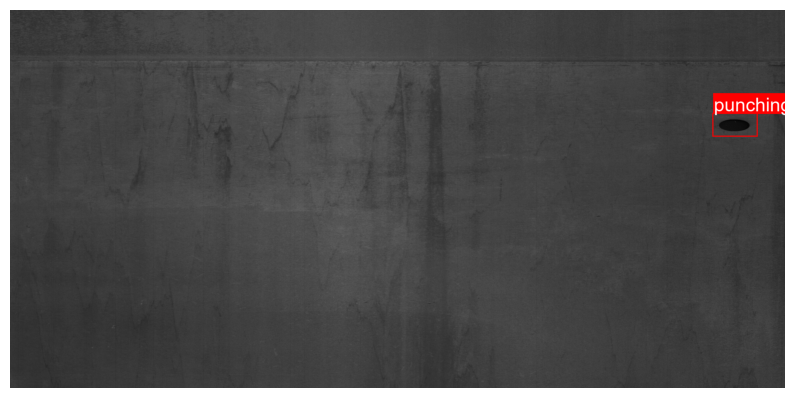

In [12]:
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform for input
transform = T.Compose([
    T.ToTensor()
])

def predict_and_visualize(image_path, model, label_map, score_thresh=0.5):
    """
    Runs inference on an image and visualizes the predicted bounding boxes.
    label_map: dict {class_id: class_name}
    """
    # Load image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model([img_tensor])

    outputs = [{k: v.to("cpu") for k, v in t.items()} for t in outputs]

    draw = ImageDraw.Draw(img)
    width, height = img.size

    # Scaled font size
    font_size = max(16, height // 20)
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()

    for box, score, label in zip(outputs[0]["boxes"], outputs[0]["scores"], outputs[0]["labels"]):
        if score >= score_thresh:
            xmin, ymin, xmax, ymax = box
            xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])

            # Draw bbox
            for k in range(3):  # thicker line
                draw.rectangle(
                    [xmin-k, ymin-k, xmax+k, ymax+k],
                    outline=(255, 0, 0)
                )

            # Label text
            class_name = label_map.get(int(label), f"cls_{label}")
            text = f"{class_name}: {score:.2f}"
            text_w, text_h = draw.textlength(text, font=font), font_size

            # Background rectangle for text
            draw.rectangle(
                [xmin, ymin - text_h - 4, xmin + text_w + 4, ymin],
                fill=(255, 0, 0)
            )
            draw.text((xmin + 2, ymin - text_h - 2), text, fill=(255, 255, 255), font=font)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Example usage:
label_map = {
    1: "welding_line",
    2: "water_spot",
    3: "waist_folding",
    4: "silk_spot",
    5: "punching_hole",
    6: "rolled_pit",
    7: "oil_spot",
    8: "inclusion",
    9: "crescent_gap",
    10: "crease"
}
test_image_path = r"C:\Users\me1mna\Downloads\Defects location for metal surface\images\images\punching_hole\img_06_425613600_00581.jpg"

predict_and_visualize(
    test_image_path,
    model,
    label_map,
    score_thresh=0.5
)



Target class: 6, Score: 0.998


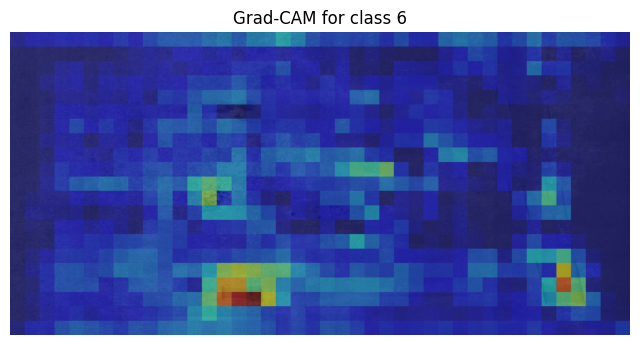

In [13]:
import torch
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from captum.attr import LayerGradCam, LayerAttribution
# Pick target detection index & image
test_image_path = r"C:\Users\me1mna\Downloads\Defects location for metal surface\images\images\rolled_pit\img_02_4402117200_00004.jpg"
transform = T.Compose([T.ToTensor()])
image = Image.open(test_image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

model.eval()
outputs = model(input_tensor)

scores = outputs[0]['scores']
target_idx = torch.argmax(scores).item()
target_class = outputs[0]['labels'][target_idx].item()

print(f"Target class: {target_class}, Score: {scores[target_idx]:.3f}")

# Custom forward to extract one detection's score
def forward_fn(x):
    out = model(x)
    # Extract score of target detection
    return out[0]['scores'][target_idx].unsqueeze(0)

# GradCAM on a layer from backbone
target_layer = model.backbone.body.layer4
gradcam = LayerGradCam(forward_fn, target_layer)

attributions = gradcam.attribute(input_tensor)

# Upsample to image size
attributions_upsampled = LayerAttribution.interpolate(attributions, image.size[::-1])
heatmap = attributions_upsampled.squeeze().cpu().detach().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= heatmap.max()

# Show
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis("off")
plt.title(f"Grad-CAM for class {target_class}")
plt.show()


In [14]:
# Save model weights
torch.save(model.state_dict(), "fasterrcnn_metal_defects50.pth")
print("Model saved to fasterrcnn_metal_defects50.pth")


Model saved to fasterrcnn_metal_defects50.pth


In [15]:
# Save whole model instead of just state_dict
torch.save(model, "fasterrcnn_metal_defects_full50.pth")


In [16]:
model = torch.load("fasterrcnn_metal_defects_full50.pth", map_location=device)
model.to(device)
model.eval()


C:\Users\me1mna\AppData\Local\Temp\ipykernel_36908\2835733468.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("fasterrcnn_metal_defects_full50.pth", m

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

C:\Users\me1mna\AppData\Local\Temp\ipykernel_36908\300715108.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("fasterrcnn_metal_defects_full50.pth", m

Target class: rolled_pit, Score: 0.998


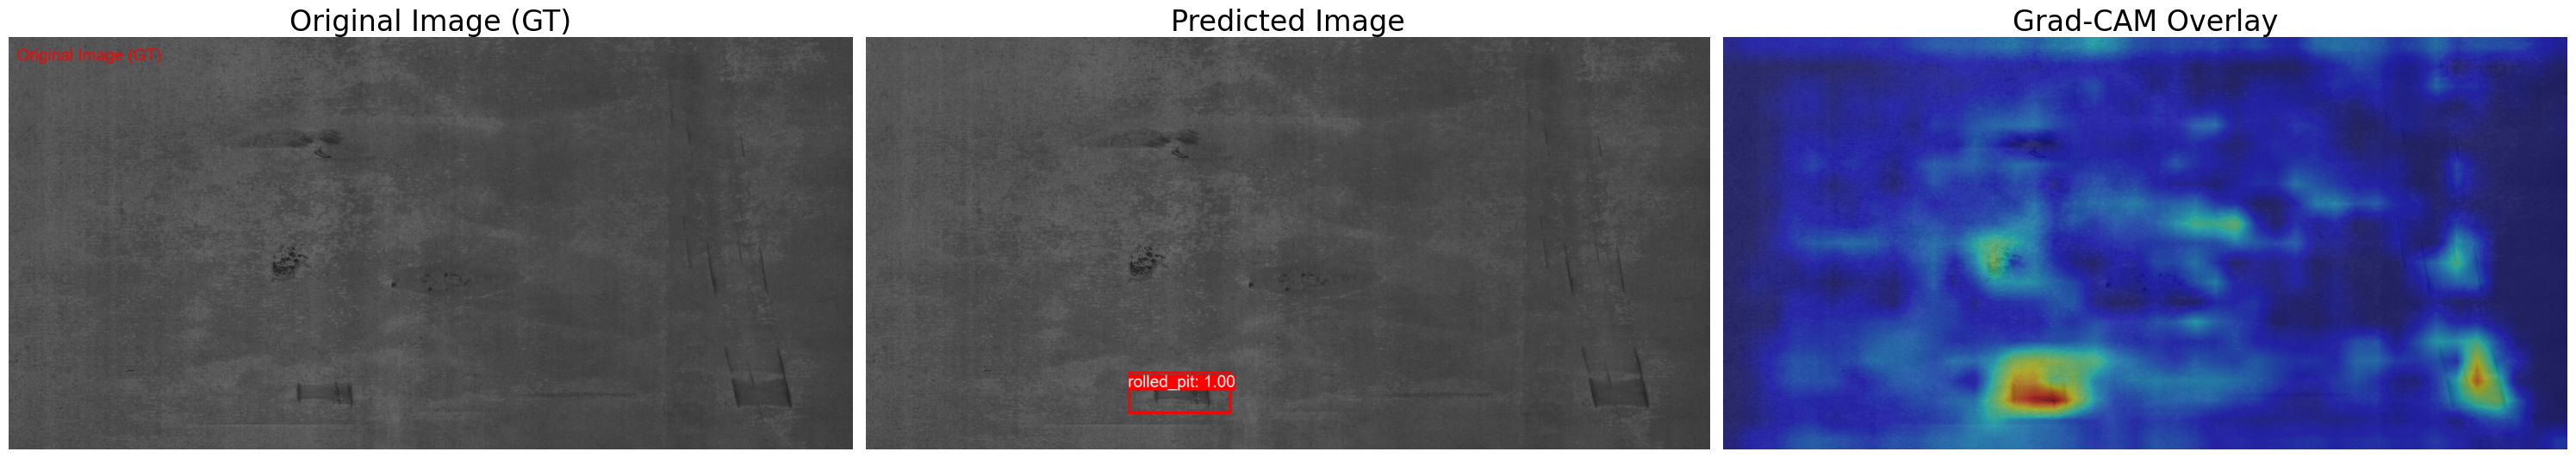

In [26]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# === Load model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("fasterrcnn_metal_defects_full50.pth", map_location=device)
model.to(device)
model.eval()

# Class names
class_names = [
    "welding_line",
    "water_spot",
    "waist folding",
    "silk_spot",
    "punching_hole",
    "rolled_pit",
    "oil_spot",
    "inclusion",
    "crescent_gap",
    "crease"
]

# === Test image ===
test_image_path = r"C:\Users\me1mna\Downloads\Defects location for metal surface\images\images\rolled_pit\img_02_4402117200_00004.jpg"
image = Image.open(test_image_path).convert("RGB")
transform = T.Compose([T.ToTensor()])
input_tensor = transform(image).unsqueeze(0).to(device)

# === Hook storage ===
gradients, activations = [], []

def save_gradients(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def save_activations(module, input, output):
    activations.append(output)

# === Target layer ===
target_layer = model.backbone.body.layer4
gradients.clear()
activations.clear()
forward_handle = target_layer.register_forward_hook(save_activations)
backward_handle = target_layer.register_full_backward_hook(save_gradients)

# === Forward pass ===
outputs = model(input_tensor)
scores = outputs[0]['scores'].detach().cpu()
labels = outputs[0]['labels'].detach().cpu()
boxes = outputs[0]['boxes'].detach().cpu()

# Pick best detection
target_idx = torch.argmax(scores).item()
label_id = labels[target_idx].item()
target_class = class_names[label_id - 1] if 1 <= label_id <= len(class_names) else str(label_id)
print(f"Target class: {target_class}, Score: {scores[target_idx]:.3f}")

# === Backward pass ===
score = outputs[0]['scores'][target_idx]
model.zero_grad()
score.backward()

# === Grad-CAM ===
grads = gradients[0].detach()
acts = activations[0].detach()
weights = grads.mean(dim=[2, 3], keepdim=True)
cam = (weights * acts).sum(dim=1).squeeze()
cam = torch.relu(cam)
cam -= cam.min()
cam /= cam.max()

cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=image.size[::-1], mode='bilinear', align_corners=False)
cam = cam.squeeze().detach().cpu().numpy()

forward_handle.remove()
backward_handle.remove()

# === Drawing ===
font_large = ImageFont.truetype("arial.ttf", 40)

# Original image (GT placeholder)
orig_img = image.copy()
draw_orig = ImageDraw.Draw(orig_img)
draw_orig.text((20, 20), "Original Image (GT)", fill="red", font=font_large)

# Predicted image
pred_img = image.copy()
draw_pred = ImageDraw.Draw(pred_img)
x1, y1, x2, y2 = boxes[target_idx]
draw_pred.rectangle([x1, y1, x2, y2], outline="red", width=6)
text = f"{target_class}: {scores[target_idx]:.2f}"
bbox = draw_pred.textbbox((x1, y1), text, font=font_large)
draw_pred.rectangle(bbox, fill="red")
draw_pred.text((x1, y1), text, fill="white", font=font_large)

# Grad-CAM overlay
cam_img = np.array(image).astype(np.float32) / 255.0
heatmap = plt.cm.jet(cam)[..., :3]
overlay = 0.5 * cam_img + 0.5 * heatmap
overlay = np.clip(overlay, 0, 1)

# === Plot big ===
fig, axes = plt.subplots(1, 3, figsize=(30, 12))

axes[0].imshow(orig_img)
axes[0].set_title("Original Image (GT)", fontsize=24)

axes[1].imshow(pred_img)
axes[1].set_title("Predicted Image", fontsize=24)

axes[2].imshow(overlay)
axes[2].set_title("Grad-CAM Overlay", fontsize=24)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from captum.attr import Saliency, Occlusion
import torch.nn.functional as F

# ==== CONFIG ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = [
    "welding_line",
    "water_spot",
    "waist folding",
    "silk_spot",
    "punching_hole",
    "rolled_pit",
    "oil_spot",
    "inclusion",
    "crescent_gap",
    "crease"
]
test_image_path = r"C:\Users\me1mna\Downloads\Defects location for metal surface\images\images\rolled_pit\img_02_4402117200_00004.jpg"

# ==== LOAD MODEL ====
model = torch.load("fasterrcnn_metal_defects_full50.pth", map_location=device)
model.to(device)
model.eval()

# ==== PREPARE IMAGE ====
transform = T.Compose([T.ToTensor()])
image = Image.open(test_image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# ==== PREDICT ====
outputs = model(input_tensor)
scores = outputs[0]['scores'].detach().cpu()
labels = outputs[0]['labels'].detach().cpu()
boxes = outputs[0]['boxes'].detach().cpu()

top_idx = torch.argmax(scores).item()
target_class_idx = labels[top_idx].item() - 1
target_class_name = class_names[target_class_idx]
target_score = scores[top_idx].item()

print(f"Target class: {target_class_name}, Score: {target_score:.3f}")

# ==== DRAW PREDICTED IMAGE ====
font_large = ImageFont.truetype("arial.ttf", 28)
pred_img = image.copy()
draw_pred = ImageDraw.Draw(pred_img)
for box, label, score in zip(boxes, labels, scores):
    if score > 0.5:
        cname = class_names[label - 1]
        draw_pred.rectangle(box.tolist(), outline="red", width=4)
        draw_pred.text((box[0], box[1] - 30), f"{cname}: {score:.2f}", fill="red", font=font_large)

# ==== HOOKS FOR GRAD-CAM ====
activations, gradients = [], []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

target_layer = model.backbone.body.layer4
forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_full_backward_hook(backward_hook)

model.zero_grad()
out = model(input_tensor)
score = out[0]['scores'][top_idx]
score.backward()

acts = activations[0].detach()
grads = gradients[0].detach()
weights = grads.mean(dim=[2, 3], keepdim=True)
cam = (acts * weights).sum(dim=1).squeeze()
cam = torch.clamp(cam, min=0)
cam = cam / cam.max()
cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=image.size[::-1], mode='bilinear', align_corners=False)
cam = cam.squeeze().cpu().numpy()

forward_handle.remove()
backward_handle.remove()

# ==== OCCLUSION ====
def model_forward(img_tensor):
    return model(img_tensor)[0]['scores'][top_idx].unsqueeze(0)

occlusion = Occlusion(model_forward)
occlusion_map = occlusion.attribute(input_tensor, strides=(3, 8, 8),
                                    sliding_window_shapes=(3, 15, 15), baselines=0)
occlusion_map = occlusion_map.squeeze().cpu().numpy()
occlusion_map = np.abs(occlusion_map).mean(axis=0)
occlusion_map /= occlusion_map.max()

# ==== SALIENCY ====
saliency = Saliency(model_forward)
saliency_map = saliency.attribute(input_tensor)
saliency_map = saliency_map.squeeze().cpu().numpy()
saliency_map = np.abs(saliency_map).mean(axis=0)
saliency_map /= saliency_map.max()

# ==== PLOT ====
fig, axs = plt.subplots(1, 4, figsize=(28, 8))

axs[0].imshow(pred_img)
axs[0].set_title("Predictions", fontsize=20)
axs[0].axis("off")

axs[1].imshow(image)
axs[1].imshow(cam, cmap='jet', alpha=0.5)
axs[1].set_title("Grad-CAM", fontsize=20)
axs[1].axis("off")

axs[2].imshow(image)
axs[2].imshow(occlusion_map, cmap='viridis', alpha=0.5)
axs[2].set_title("Occlusion", fontsize=20)
axs[2].axis("off")

axs[3].imshow(image)
axs[3].imshow(saliency_map, cmap='hot', alpha=0.5)
axs[3].set_title("Saliency", fontsize=20)
axs[3].axis("off")

plt.tight_layout()
plt.show()


C:\Users\me1mna\AppData\Local\Temp\ipykernel_36908\246338938.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("fasterrcnn_metal_defects_full50.pth", m

Target class: rolled_pit, Score: 0.998
